In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output
from collections import deque

In [ ]:
# ==================== 第2步：扑克状态模拟 ====================
class PokerState:
    def __init__(self):
        self.state_vector = np.random.randn(128)  # 简化状态向量（可替换成PokerRL环境）


In [ ]:
# ==================== 第3步：网络定义 ====================
class StrategyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(StrategyNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.fc(x)

class AdvantageNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(AdvantageNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.fc(x)


In [ ]:
# ==================== 第4步：对手建模 ====================
class Opponent:
    def __init__(self, style='aggressive'):
        self.style = style

    def choose_action(self, state_vec):
        if self.style == 'aggressive':
            probs = [0.1, 0.2, 0.7]  # fold, call, raise
        elif self.style == 'passive':
            probs = [0.4, 0.5, 0.1]
        else:
            probs = [1/3, 1/3, 1/3]
        return np.random.choice([0, 1, 2], p=probs)


In [ ]:
# ==================== 第5步：训练器类 ====================
class DeepCFRTrainer:
    def __init__(self, state_dim, action_dim, lr=1e-4):
        self.strategy_net = StrategyNetwork(state_dim, action_dim)
        self.advantage_net = AdvantageNetwork(state_dim, action_dim)
        self.optimizer_strat = optim.Adam(self.strategy_net.parameters(), lr=lr)
        self.optimizer_adv = optim.Adam(self.advantage_net.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()
        self.memory = deque(maxlen=10000)

    def sample_action(self, state_vec):
        state_tensor = torch.FloatTensor(state_vec)
        probs = self.strategy_net(state_tensor)
        return torch.multinomial(probs, 1).item()

    def store_advantage(self, state_vec, advantage_target):
        self.memory.append((state_vec, advantage_target))

    def train_advantage_net(self):
        if len(self.memory) == 0:
            return
        batch = random.sample(self.memory, min(len(self.memory), 64))
        states, targets = zip(*batch)
        states = torch.FloatTensor(states)
        targets = torch.FloatTensor(targets)
        preds = self.advantage_net(states)
        loss = self.loss_fn(preds, targets)
        self.optimizer_adv.zero_grad()
        loss.backward()
        self.optimizer_adv.step()

    def evaluate_policy(self):
        with torch.no_grad():
            test_state = torch.FloatTensor(np.random.randn(128))
            probs = self.strategy_net(test_state)
            return probs.numpy()


Epoch: 900
Sample policy (fold/call/raise): [0.239029   0.34088627 0.4200847 ]


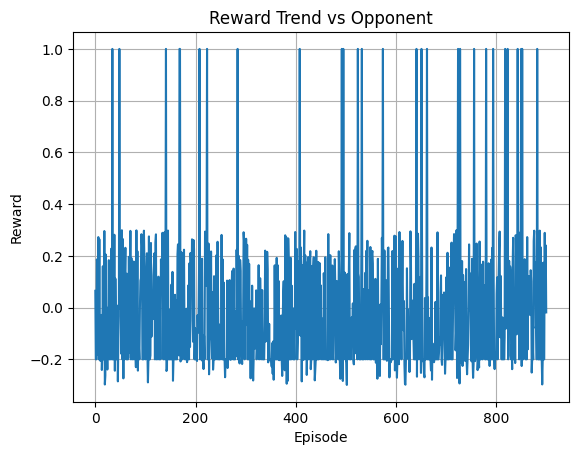

In [ ]:
# ==================== 第6步：训练与对抗 ====================
trainer = DeepCFRTrainer(state_dim=128, action_dim=3)
opponent = Opponent(style='aggressive')  # 可选 passive

reward_history = []

for epoch in range(1000):
    state = PokerState()
    action = trainer.sample_action(state.state_vector)
    opp_action = opponent.choose_action(state.state_vector)

    # 模拟奖励逻辑（可后续替换为真实扑克环境 reward）
    if action == 2 and opp_action == 0:
        reward = 1.0  # 我raise，对手fold → 赢
    elif action == 0:
        reward = -0.2  # 我fold → 输
    else:
        reward = np.random.uniform(-0.3, 0.3)

    advantage = np.zeros(3)
    advantage[action] = reward
    trainer.store_advantage(state.state_vector, advantage)

    if epoch % 10 == 0:
        trainer.train_advantage_net()

    reward_history.append(reward)

    if epoch % 100 == 0:
        clear_output(wait=True)
        print(f"Epoch: {epoch}")
        print("Sample policy (fold/call/raise):", trainer.evaluate_policy())
        plt.plot(reward_history)
        plt.xlabel("Episode")
        plt.ylabel("Reward")
        plt.title("Reward Trend vs Opponent")
        plt.grid(True)
        plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21160 (\N{CJK UNIFIED IDEOGRAPH-52A8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20316 (\N{CJK UNIFIED IDEOGRAPH-4F5C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 27010 (\N{CJK UNIFIED IDEOGRAPH-6982}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31574 (\N{CJK UNIFIED IDEOGRAPH-7B56}) missing from font(s) DejaVu Sans.
  fig.canvas

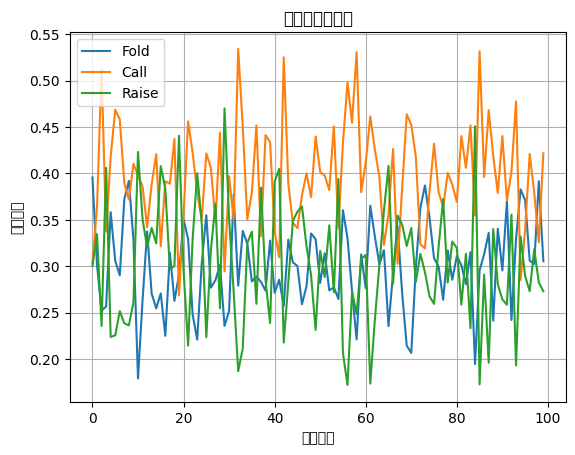

In [ ]:
# ==================== 第7步：策略演化图 ====================
folds, calls, raises = [], [], []

for _ in range(100):
    probs = trainer.evaluate_policy()
    folds.append(probs[0])
    calls.append(probs[1])
    raises.append(probs[2])

plt.plot(folds, label='Fold')
plt.plot(calls, label='Call')
plt.plot(raises, label='Raise')
plt.legend()
plt.title("策略演化趋势图")
plt.xlabel("采样轮次")
plt.ylabel("动作概率")
plt.grid(True)
plt.show()


In [ ]:
# ==================== 第8步：保存与加载模型 ====================
# 保存模型
torch.save(trainer.strategy_net.state_dict(), "strategy_model.pth")
torch.save(trainer.advantage_net.state_dict(), "advantage_model.pth")

# 加载模型
trainer.strategy_net.load_state_dict(torch.load("strategy_model.pth"))
trainer.advantage_net.load_state_dict(torch.load("advantage_model.pth"))


<All keys matched successfully>